# <span style = "background-color: #FFDDDD"> Pascal VOC challenge</span>

### 열정의백세시대: 강다은, 김찬중, 조혜원(🏅)

⭐️ 1. 적합한 로스와 메트릭을 사용하여 훈련이 이루어졌는가? 데이터셋 구성, 모델 훈련, 결과물 시각화의 한 사이클이 정상적으로 수행되어 결과 이미지를 제출하였으며, 평가 지표에 따라 모델의 평가가 이루어졌다  
⭐️ 2. 다양한 실험을 진행하였는가? 모델의 조정 및 성능 개선 기법을 통해 분기된 훈련 결과의 성능 평가 비교가 이루어졌다  
⭐️ 3. 훈련 결과 및 비교군 분석이 충실히 진행되었는가? 데이터셋 및 선택한 모델이 관련 분야의 베이스라인 모델과 비교하여 어떤 차이가 있는지 정량적, 정성적 분석을 진행하였다

---
## <span style = "background-color: #FFFFDD"> 🏃🏻 Environment Settings</span>

### <span style = "background-color: #F0E9FF"> 1. Import libraries & packages </span>

In [1]:
!pip install wandb==0.16.0

In [2]:
# useful tools
import io
import random

# data array
import numpy as np

# image data handling
from PIL import Image

# visualization
import matplotlib.pyplot as plt

# machine learning
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Rescaling, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate

# image pre-processing
from tensorflow.keras.preprocessing.image import img_to_array

# load datasets
import datasets

# analysis model performance
import wandb
from wandb.keras import WandbCallback

### <span style = "background-color: #F0E9FF"> 2. Define constants</span>

**2-1. Define constants for dataset configurations**

In [3]:
# the number of data samples
TOTAL_SAMPLES_CNT = 2913

TRAIN_SAMPLES_CNT = int(TOTAL_SAMPLES_CNT * 0.7)
VAL_SAMPLES_CNT = int(TOTAL_SAMPLES_CNT * 0.2)
TEST_SAMPLES_CNT = int(TOTAL_SAMPLES_CNT - TRAIN_SAMPLES_CNT - VAL_SAMPLES_CNT)


# image size
IMG_SIZE = 256


# segmentation information
CLASS_VALUES = [0, 132, 14, 147, 19, 150, 33, 37, 38, 52, 57, 71, 75, 89, 220, 94, 108, 112, 113, 127]
TOTAL_CLASSES_CNT = len(CLASS_VALUES) # 20
CLASS_MAPPING = {CLASS_VALUES[i]: i for i in range(TOTAL_CLASSES_CNT)}

**2-2. Define constants for model training**

In [4]:
BATCH_SIZE = 16
EPOCHS = 50

### <span style = "background-color: #F0E9FF"> 3. Define frequently used methods</span>

**3-1. Define methods to convert segmentation mask values**

In [5]:
def do_vectorize(ds_target):
    return [np.vectorize(CLASS_MAPPING.get)(img) for img in ds_target]

**3-2. Define methods to convert image data from byte data**

In [6]:
def get_img_from_bytes(img_bytes, is_input=True):
    pil_img = Image.open(io.BytesIO(img_bytes))
    tf_img = img_to_array(pil_img)
    
    if is_input == True: # (for input data)
        tf_img = tf_img / 255.
        return tf_img.astype("float32")
    
    else: # is_input == False: (for target data)
        tf_img = np.array(tf.image.rgb_to_grayscale(tf_img))
        return tf_img.astype("uint8")

**3-3. Define methods to print dividers**

In [7]:
DIVIDER_LENGTH = 80

def print_single_divider(length = DIVIDER_LENGTH):
    print("-" * DIVIDER_LENGTH)

def print_double_divider(length = DIVIDER_LENGTH):
    print("=" * DIVIDER_LENGTH)

### <span style = "background-color: #F0E9FF"> 4. Check GPU settings</span>

In [8]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

---
## <span style = "background-color: #FFFFDD"> 🏃🏻 Data Preparation</span>

### <span style = "background-color: #F0E9FF"> 1. Load dataset</span>

**1-1. Load dataset**

In [9]:
dataset = datasets.load_dataset("nateraw/pascal-voc-2012", split="train")

Using custom data configuration nateraw___pascal-voc-2012-c68607404d4811ac
Reusing dataset parquet (/aiffel/.cache/huggingface/datasets/parquet/nateraw___pascal-voc-2012-c68607404d4811ac/0.0.0/9296ce43568b20d72ff8ff8ecbc821a16b68e9b8b7058805ef11f06e035f911a)


**1-2. Check the dataset**

In [10]:
print(dataset)

Dataset({
    features: ['image', 'mask'],
    num_rows: 2913
})


**1-3. Set constant values for the numbers of data samples**

In [11]:
TOTAL_SAMPLES_CNT = 200 # dataset.num_rows

TRAIN_SAMPLES_CNT = int(TOTAL_SAMPLES_CNT * 0.7)
VAL_SAMPLES_CNT = int(TOTAL_SAMPLES_CNT * 0.2)
TEST_SAMPLES_CNT = int(TOTAL_SAMPLES_CNT - TRAIN_SAMPLES_CNT - VAL_SAMPLES_CNT)

**1-4. Convert bytes dat into image data**

⚠️ This takes much time! Please ait with patience...

In [12]:
ds_input_original = [get_img_from_bytes(dataset["image"][i]["bytes"]) for i in range(TOTAL_SAMPLES_CNT)]

print("> Byte-dataset for INPUT has converted into image dataset successfully!")

> Byte-dataset for INPUT has converted into image dataset successfully!


In [13]:
ds_target_original = [get_img_from_bytes(dataset["mask"][i]["bytes"], is_input=False) for i in range(TOTAL_SAMPLES_CNT)]
ds_target_original = do_vectorize(ds_target_original)

print("> Byte-dataset for TARGET has converted into image dataset successfully!")

> Byte-dataset for TARGET has converted into image dataset successfully!


### <span style = "background-color: #F0E9FF"> 2. Split data</span>

In [14]:
ds_train_input_original = ds_input_original[:TRAIN_SAMPLES_CNT]
ds_train_target_original = ds_target_original[:TRAIN_SAMPLES_CNT]

ds_val_input = ds_input_original[TRAIN_SAMPLES_CNT:TRAIN_SAMPLES_CNT+VAL_SAMPLES_CNT]
ds_val_target = ds_target_original[TRAIN_SAMPLES_CNT:TRAIN_SAMPLES_CNT+VAL_SAMPLES_CNT]

ds_test_input = ds_input_original[TRAIN_SAMPLES_CNT+VAL_SAMPLES_CNT:]
ds_test_target = ds_target_original[TRAIN_SAMPLES_CNT+VAL_SAMPLES_CNT:]

print("> Dataset divded into train, validation, test parts successfully!")

> Dataset divded into train, validation, test parts successfully!


### <span style = "background-color: #F0E9FF"> 3. Augment data</span>

**3-1. Define augmentation method**

In [15]:
def do_augment(ds_input_original, ds_target_original):
    # original input & segmented target 동시에 동일한 augmentation 작업을 수행하기 위해,
    # 함수 parameter를 통해 input & target 쌍을 함께 전달
    
    # check whether input & target matches
    if len(ds_input_original) != len(ds_target_original):
        print("> ERROR: The numbers of original input images and segmented target images do not match!!")
        return None
    
    
    ds_input_augmented = []
    ds_target_augmented = []
    
    for i in range(len(ds_input_original)):
        input_img = ds_input_original[i]
        target_img = ds_target_original[i]
        
        # horizon flip
        if random.random() >= 0.5:
            input_img = tf.image.flip_left_right(input_img)
            target_img = tf.image.flip_left_right(target_img)
        
        # zoom center
        if random.random() >= 0.5:
            input_img = tf.image.central_crop(input_img, 0.9)
            target_img = tf.image.central_crop(target_img, 0.9)
            
        # adjust brightness (input only, no target)
        if random.random() >= 0.5:
            input_img = tf.image.adjust_brightness(input_img, 0.2)
            input_img = np.clip(input_img, 0, 1)    # ignore over-adjusted value
        
        # adjust saturation (input only, no target)
        if random.random() >= 0.5:
            input_img = tf.image.adjust_saturation(input_img, 0.5)
            input_img = np.clip(input_img, 0, 1)    # ignore over-adjusted value
            
        ds_input_augmented.append(np.array(input_img))
        ds_target_augmented.append(np.array(target_img))
       
    
    return ds_input_augmented, ds_target_augmented

**3-2. Perform augmentation for train data**

In [16]:
ds_train_input_augmented, ds_train_target_augmented = do_augment(ds_train_input_original, ds_train_target_original)

print("> Data augmentation on training data performed successfully!")

> Data augmentation on training data performed successfully!


**3-3. Preview image data samples**

In [17]:
def preview_original_augmented_img(sample_cnt):
    sample_num_list = [random.randint(0, TRAIN_SAMPLES_CNT-1) for _ in range(sample_cnt)]
     
    for i in range(sample_cnt):
        # get image data from the sample data
        sample_num = sample_num_list[i]

        fig = plt.figure(figsize=(15, 4))

        ax1 = fig.add_subplot(1, 4, 1)
        ax1.imshow(ds_train_input_original[i])
        ax1.set_title("ORIGINAL INPUT (" + str(sample_num) + ")")
        ax1.axis("off")

        ax2 = fig.add_subplot(1, 4, 2)
        ax2.imshow(ds_train_target_original[i] / (TOTAL_CLASSES_CNT - 1))
        ax2.set_title("ORIGINAL TARGET (" + str(sample_num) + ")")
        ax2.axis("off")

        ax3 = fig.add_subplot(1, 4, 3)
        ax3.imshow(ds_train_input_augmented[i])
        ax3.set_title("AUGMENTED INPUT (" + str(sample_num) + ")")
        ax3.axis("off")

        ax4 = fig.add_subplot(1, 4, 4)
        ax4.imshow(ds_train_target_augmented[i] / (TOTAL_CLASSES_CNT - 1))
        ax4.set_title("AUGMENTED TARGET (" + str(sample_num) + ")")
        ax4.axis("off")

        plt.tight_layout()
        plt.show()

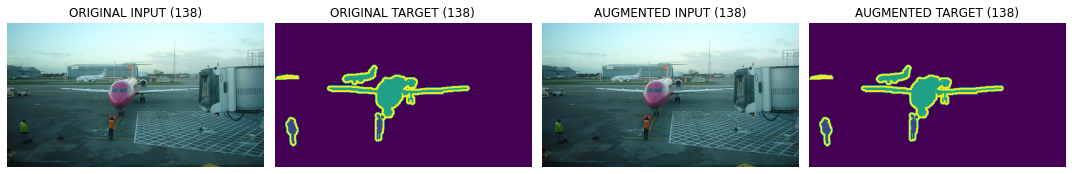

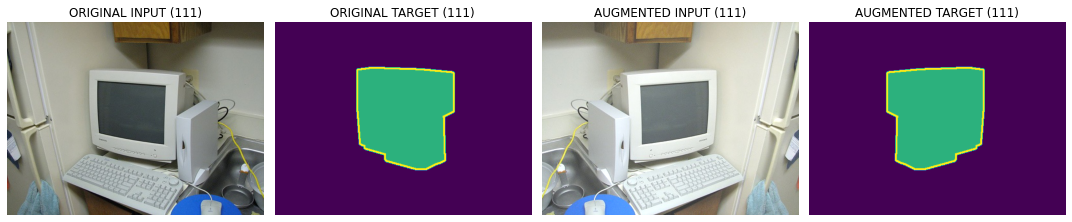

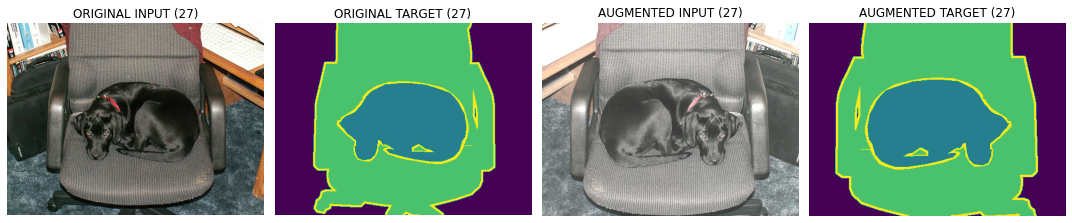

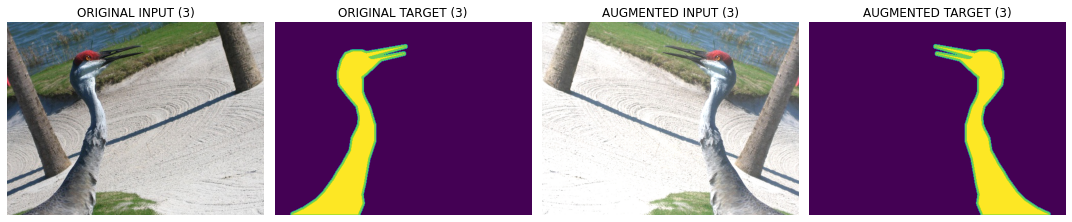

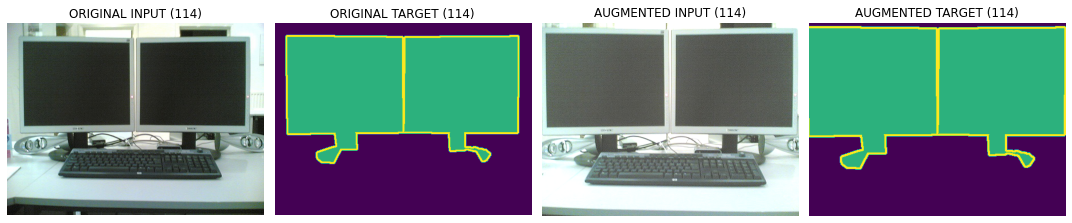

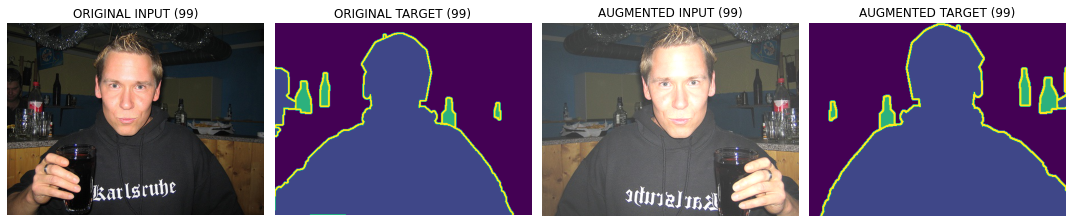

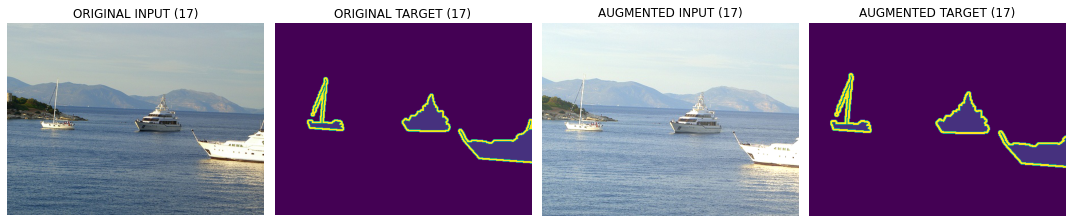

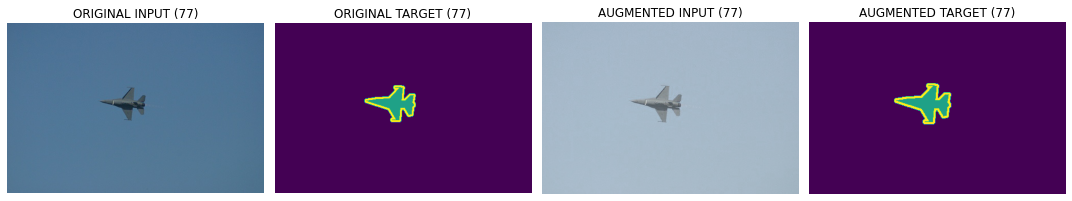

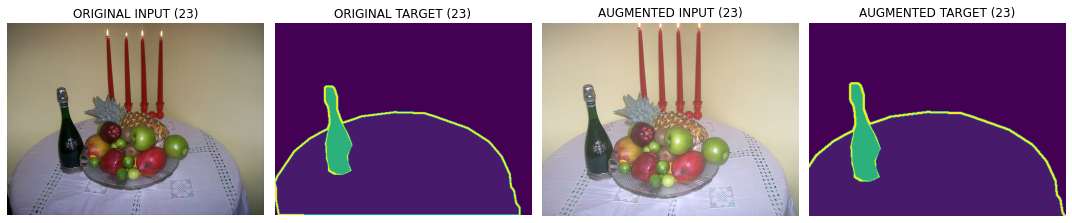

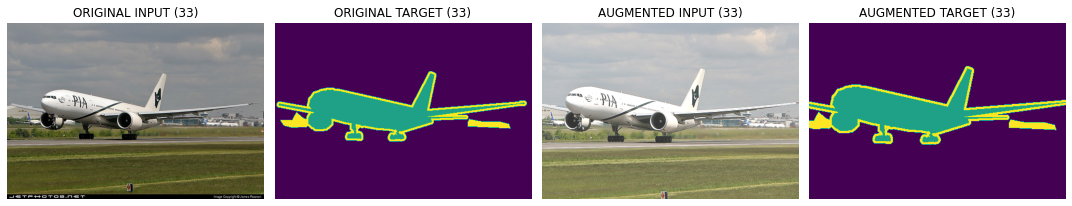

In [18]:
preview_original_augmented_img(10)

### <span style = "background-color: #F0E9FF"> 4. Pre-process data</span>

**4-1. Define resizing method**

In [19]:
def do_resizing(ds, size=(IMG_SIZE, IMG_SIZE), is_input=True):
    if is_input == True: # input data
        return [np.array(tf.image.resize(img, [IMG_SIZE, IMG_SIZE])) for img in ds]
    else: # target data
        return [np.clip(np.array(tf.image.resize(img, [IMG_SIZE, IMG_SIZE])), 0, 19) for img in ds]

**4-2. Perform resizing on the whole dataset**

In [20]:
ds_train_input_original = do_resizing(ds_train_input_original)
ds_train_target_original = do_resizing(ds_train_target_original, is_input=False)

ds_train_input_augmented = do_resizing(ds_train_input_augmented)
ds_train_target_augmented = do_resizing(ds_train_target_augmented, is_input=False)

ds_val_input = do_resizing(ds_val_input)
ds_val_target = do_resizing(ds_val_target, is_input=False)

ds_test_input = do_resizing(ds_test_input)
ds_test_target = do_resizing(ds_test_target, is_input=False)


print("> Image dataset resized into (" + str(IMG_SIZE) + ", " + str(IMG_SIZE) + ") successfully!")

> Image dataset resized into (256, 256) successfully!


**4-3. Preview resized image data samples**

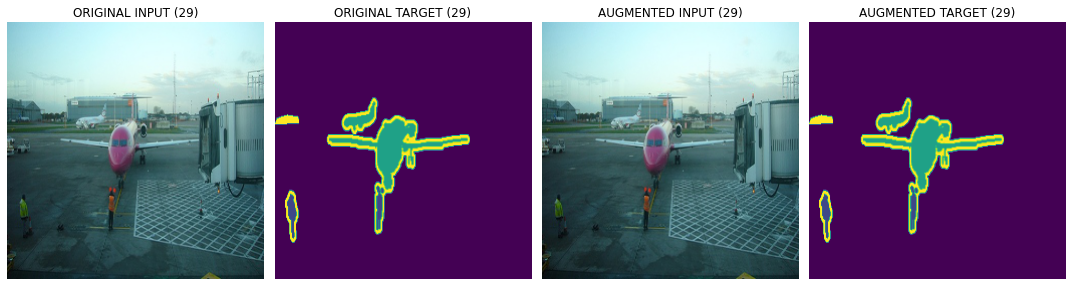

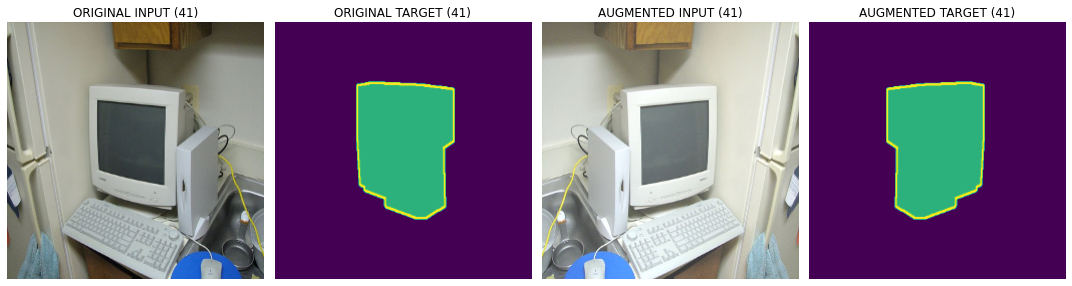

In [21]:
preview_original_augmented_img(2)

### <span style = "background-color: #F0E9FF"> 5. Prepare final training-ready data</span>

**5-1. Normalize & integrate samples into one tensor**

In [22]:
ds_train_input_original = np.stack(ds_train_input_original, axis=0)
ds_train_target_original = np.stack(ds_train_target_original, axis=0).astype(np.uint8) #/ 255.

ds_train_input_augmented = np.stack(ds_train_input_augmented, axis=0)
ds_train_target_augmented = np.stack(ds_train_target_augmented, axis=0).astype(np.uint8) #/ 255.

ds_val_input = np.stack(ds_val_input, axis=0)
ds_val_target = np.stack(ds_val_target, axis=0).astype(np.uint8) #/ 255.

ds_test_input = np.stack(ds_test_input, axis=0)
ds_test_target = np.stack(ds_test_target, axis=0).astype(np.uint8) #/ 255.

In [23]:
print("> All data prepared successfully!")
print_double_divider()

print("> Shape of original  input  data for training   : ", ds_train_input_original.shape, ds_train_input_original.dtype)
print("> Shape of original  target data for training   : ", ds_train_target_original.shape, ds_train_target_original.dtype)
print_single_divider()

print("> Shape of augmented input  data for training   : ", ds_train_input_augmented.shape, ds_train_input_augmented.dtype)
print("> Shape of augmented target data for training   : ", ds_train_target_augmented.shape, ds_train_target_augmented.dtype)
print_single_divider()

print("> Shape of           input  data for validation : ", ds_val_input.shape, ds_val_input.dtype)
print("> Shape of           target data for validation : ", ds_val_target.shape, ds_val_target.dtype)
print_single_divider()

print("> Shape of           input  data for test       : ", ds_test_input.shape, ds_test_input.dtype)
print("> Shape of           target data for test       : ", ds_test_target.shape, ds_test_target.dtype)
print_single_divider()

> All data prepared successfully!
> Shape of original  input  data for training   :  (140, 256, 256, 3) float32
> Shape of original  target data for training   :  (140, 256, 256, 1) uint8
--------------------------------------------------------------------------------
> Shape of augmented input  data for training   :  (140, 256, 256, 3) float32
> Shape of augmented target data for training   :  (140, 256, 256, 1) uint8
--------------------------------------------------------------------------------
> Shape of           input  data for validation :  (40, 256, 256, 3) float32
> Shape of           target data for validation :  (40, 256, 256, 1) uint8
--------------------------------------------------------------------------------
> Shape of           input  data for test       :  (20, 256, 256, 3) float32
> Shape of           target data for test       :  (20, 256, 256, 1) uint8
--------------------------------------------------------------------------------


---
## <span style = "background-color: #FFFFDD"> 🏃🏻 Model Preparation</span>

### <span style = "background-color: #F0E9FF"> 1. Define methods to adopt CAM to models</span>

In [24]:
def get_cam_from_model(model, num_classes=TOTAL_CLASSES_CNT):
    x = model.output
    preds = keras.layers.Dense(num_classes, activation="softmax")(x)
    cam_model = keras.Model(inputs=model.input, outputs=preds)
    return cam_model

### <span style = "background-color: #F0E9FF"> 2. Prepare U-net model with CAM</span>

**2-1. Define U-net model structure** 

In [25]:
def get_unet_model(input_shape=(IMG_SIZE,IMG_SIZE,3), num_classes=TOTAL_CLASSES_CNT):
    # input layer
    inputs = Input(input_shape)
       
    # contracting path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # bottom (center)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # expanding path
    up6 = Concatenate()([UpSampling2D(size=(2, 2))(conv5), conv4])
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Concatenate()([UpSampling2D(size=(2, 2))(conv6), conv3])
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Concatenate()([UpSampling2D(size=(2, 2))(conv7), conv2])
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Concatenate()([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    
    # output layer
    #outputs = Conv2D(num_classes, 1, activation='softmax', padding="same")(conv9)
    outputs = Conv2D(num_classes, 1, activation="linear", padding="same")(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    
    return model

**2-2. Generate U-net model instances**

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
____________________________________________________________________________________________

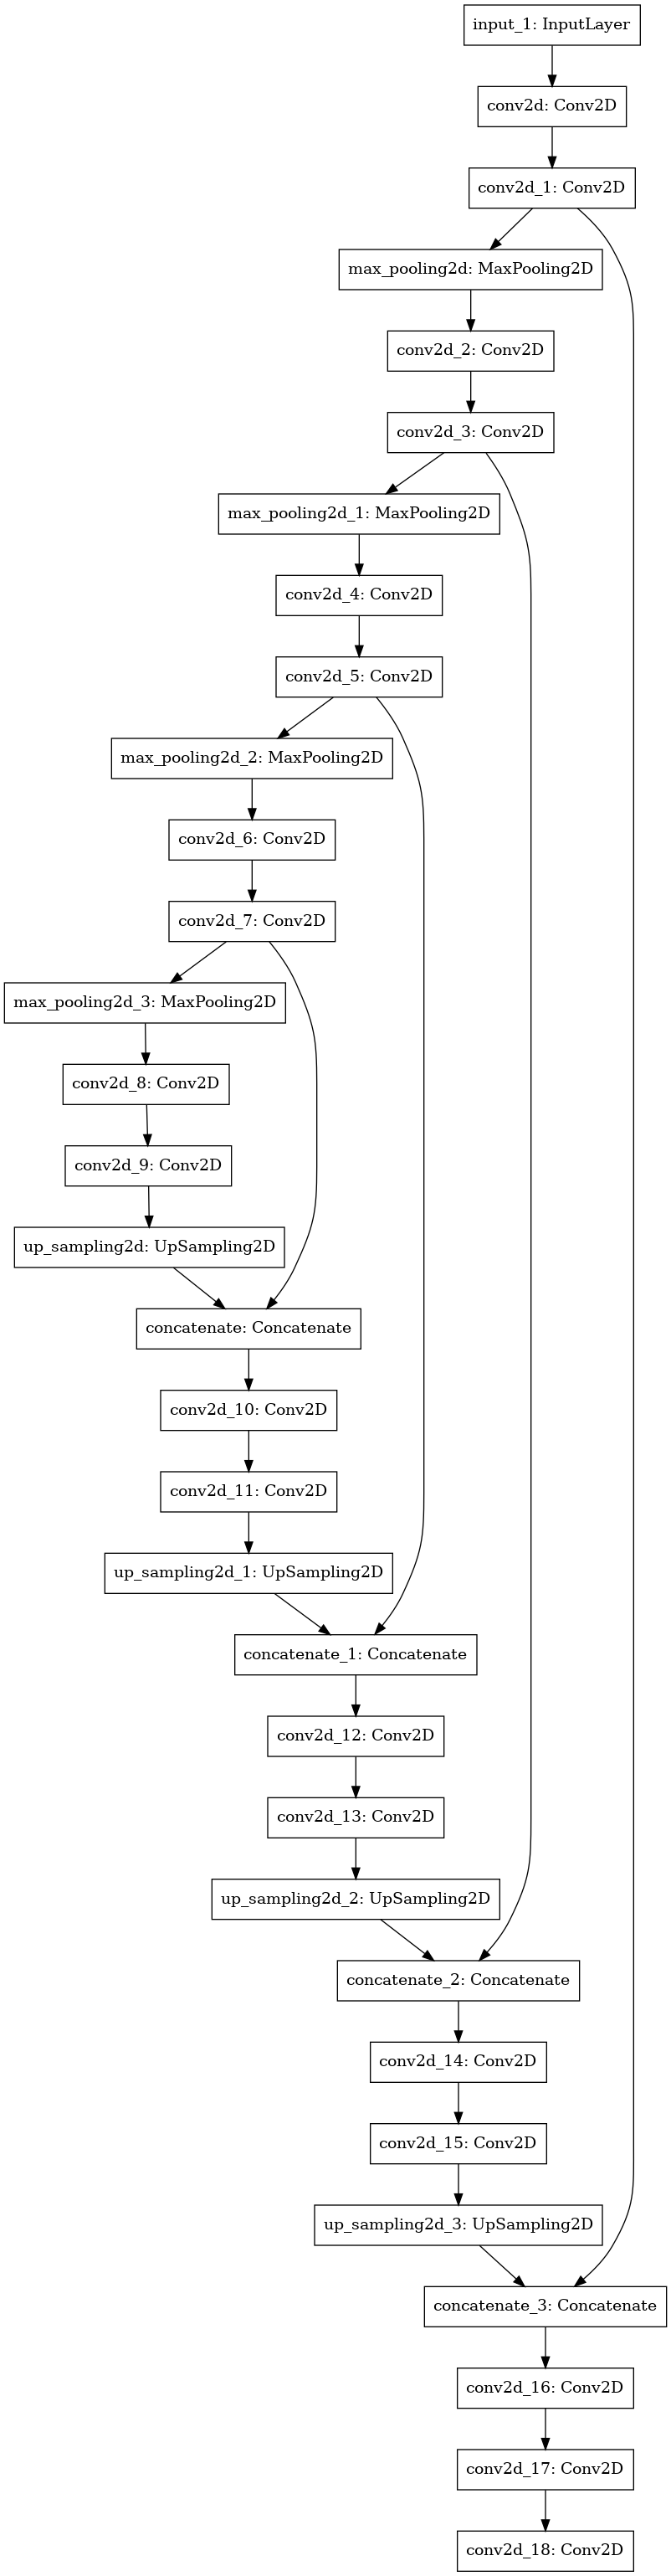

In [26]:
unet_ori_model = get_unet_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=TOTAL_CLASSES_CNT)
unet_cam_ori_model = get_cam_from_model(unet_ori_model)

unet_cam_ori_model.summary()
keras.utils.plot_model(unet_ori_model, show_shapes=False)

In [27]:
#unet_aug_model = get_unet_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=TOTAL_CLASSES_CNT)
#unet_cam_aug_model = get_cam_from_model(unet_aug_model)

### <span style = "background-color: #F0E9FF">  3. Prepare FCN model with CAM</span>

**3-1. Define FCN model structure** 

In [28]:
#def get_fcn_model(input_shape=(IMG_SIZE,IMG_SIZE,3), num_classes=TOTAL_CLASSES_CNT):
    
    #implement here later ...
    
    #return model

**3-2. Generate FCN model instances**

In [29]:
#fcn_ori_model = get_fcn_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=TOTAL_CLASSES_CNT)
#fcn_cam_ori_model = get_cam_from_model(fcn_ori_model)

#fcn_cam_ori_model.summary()
#keras.utils.plot_model(deeplab_ori_model, show_shapes=False)

In [30]:
#fcn_aug_model = get_fcn_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=TOTAL_CLASSES_CNT)
#fcn_cam_aug_model = get_cam_from_model(fcn_aug_model)

### <span style = "background-color: #F0E9FF">  4. Prepare DeepLab model with CAM</span>

**4-1. Define DeepLab model structure** 

In [31]:
def deeplab_conv_block(block_input, num_filters = 256, kernel_size =3,
                     dilation_rate = 1, padding = 'same', use_bias = False):
    x = layers.Conv2D(num_filters, kernel_size=kernel_size, 
                      dilation_rate=dilation_rate, padding = 'same', 
                      use_bias = use_bias, kernel_initializer = keras.initializers.HeNormal())(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)

In [32]:
def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = deeplab_conv_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation='bilinear')(x)
    
    out_1 = deeplab_conv_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = deeplab_conv_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = deeplab_conv_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = deeplab_conv_block(dspp_input, kernel_size=3, dilation_rate=18)
    
    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = deeplab_conv_block(x, kernel_size=1)
    return output

In [33]:
def get_deeplab_model(input_shape=(IMG_SIZE,IMG_SIZE,3), num_classes=TOTAL_CLASSES_CNT):
    # input layer
    inputs = keras.Input(input_shape)
    
    resnet50 = keras.applications.ResNet50(weights = 'imagenet', include_top = False, input_tensor = inputs)
    
    x = resnet50.get_layer('conv4_block6_2_relu').output
    x = DilatedSpatialPyramidPooling(x)
    
    input_a = layers.UpSampling2D(size = (IMG_SIZE // 4 // x.shape[1],
                                         IMG_SIZE // 4 // x.shape[2]),
                                 interpolation = 'bilinear')(x)
    
    input_b = resnet50.get_layer('conv2_block3_2_relu').output
    input_b = deeplab_conv_block(input_b, num_filters = 48, kernel_size = 1)
    
    x = layers.Concatenate(axis = -1)([input_a, input_b])
    x = deeplab_conv_block(x)
    x = deeplab_conv_block(x)
    x = layers.UpSampling2D(size = (IMG_SIZE // x.shape[1],
                                   IMG_SIZE // x.shape[2]),
                           interpolation = 'bilinear')(x)
    
    outputs = layers.Conv2D(num_classes, kernel_size = (1, 1), padding = 'same')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

**4-2. Generate DeepLab model instances**

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

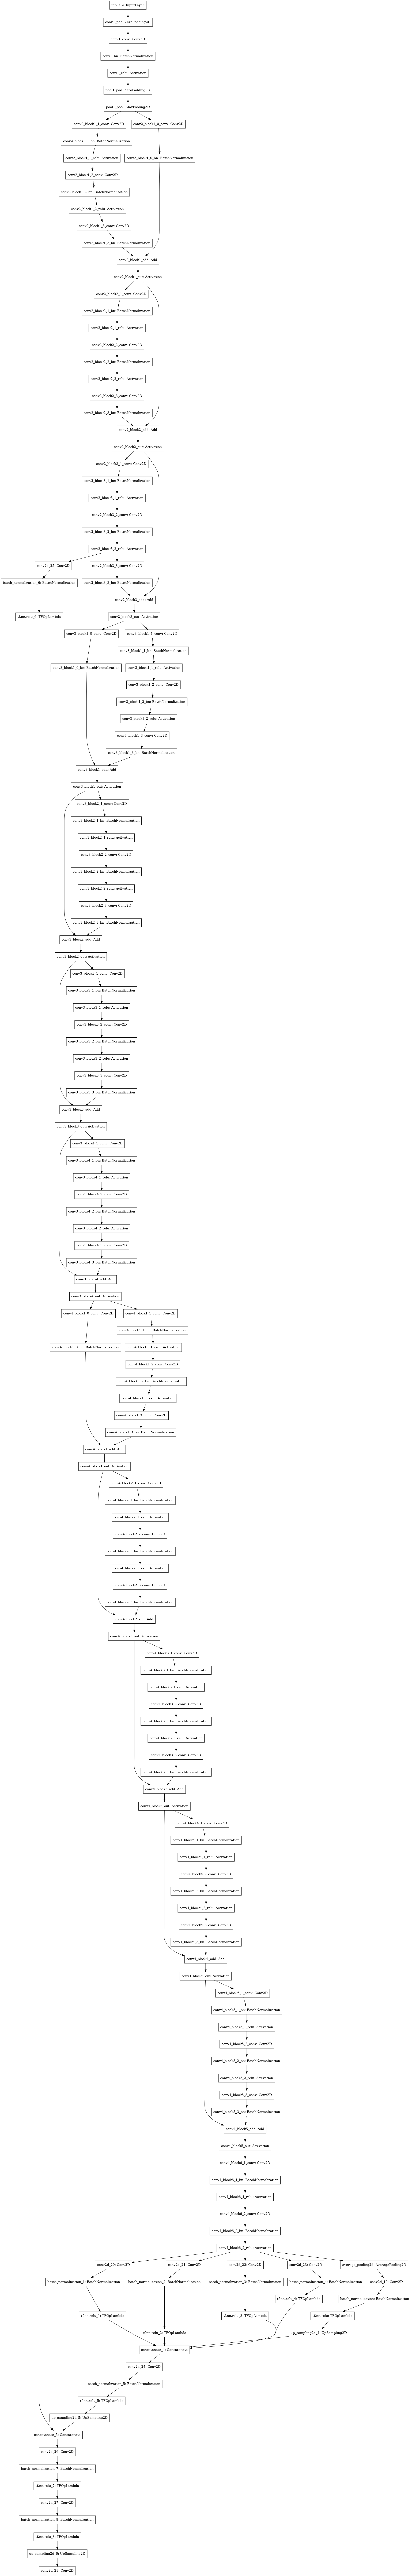

In [34]:
deeplab_ori_model = get_deeplab_model(input_shape=(IMG_SIZE,IMG_SIZE,3), num_classes=TOTAL_CLASSES_CNT)
deeplab_cam_ori_model = get_cam_from_model(deeplab_ori_model)

deeplab_cam_ori_model.summary()
keras.utils.plot_model(deeplab_ori_model, show_shapes=False)

In [35]:
#deeplab_aug_model = get_deeplab_model(input_shape=(IMG_SIZE,IMG_SIZE,3), num_classes=TOTAL_CLASSES_CNT)
#deeplab_cam_aug_model = get_cam_from_model(deeplab_aug_model)

### <span style = "background-color: #F0E9FF">  5. Prepare Panoptic model with CAM</span>

**5-1. Define Panoptic model structure** 

In [36]:
def panoptic_conv_block(x, filters, kernel_size=3, padding='same', activation='relu'):
    x = layers.Conv2D(filters, kernel_size, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    return x

In [37]:
def get_panoptic_model(input_shape=(IMG_SIZE,IMG_SIZE,3), num_classes=TOTAL_CLASSES_CNT, num_instances=TOTAL_CLASSES_CNT):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Encoder
    conv1 = panoptic_conv_block(inputs, 64)
    conv1 = panoptic_conv_block(conv1, 64)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = panoptic_conv_block(pool1, 128)
    conv2 = panoptic_conv_block(conv2, 128)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = panoptic_conv_block(pool2, 256)
    conv3 = panoptic_conv_block(conv3, 256)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Decoder
    up4 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv3)
    up4 = layers.concatenate([up4, conv2], axis=3)
    conv4 = panoptic_conv_block(up4, 128)
    conv4 = panoptic_conv_block(conv4, 128)

    up5 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv4)
    up5 = layers.concatenate([up5, conv1], axis=3)
    conv5 = panoptic_conv_block(up5, 64)
    conv5 = panoptic_conv_block(conv5, 64)

    # Output layer for semantic segmentation
    #sem_seg_output = layers.Conv2D(num_classes, (1, 1), activation='softmax', name='sem_seg')(conv5)
    sem_seg_output = layers.Conv2D(num_classes, (1, 1), activation="linear", name='sem_seg')(conv5)
    
    # Output layer for instance segmentation
    #ins_seg_output = layers.Conv2D(num_instances, (1, 1), activation='sigmoid', name='ins_seg')(conv5)

    #model = Model(inputs, [sem_seg_output, ins_seg_output])
    model = Model(inputs=inputs, outputs=sem_seg_output)
    
    return model

**5-2. Generate Panoptic model instances**

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 256, 256, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 256, 256, 64) 256         conv2d_29[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           batch_normalization_9[0][0]      
____________________________________________________________________________________________

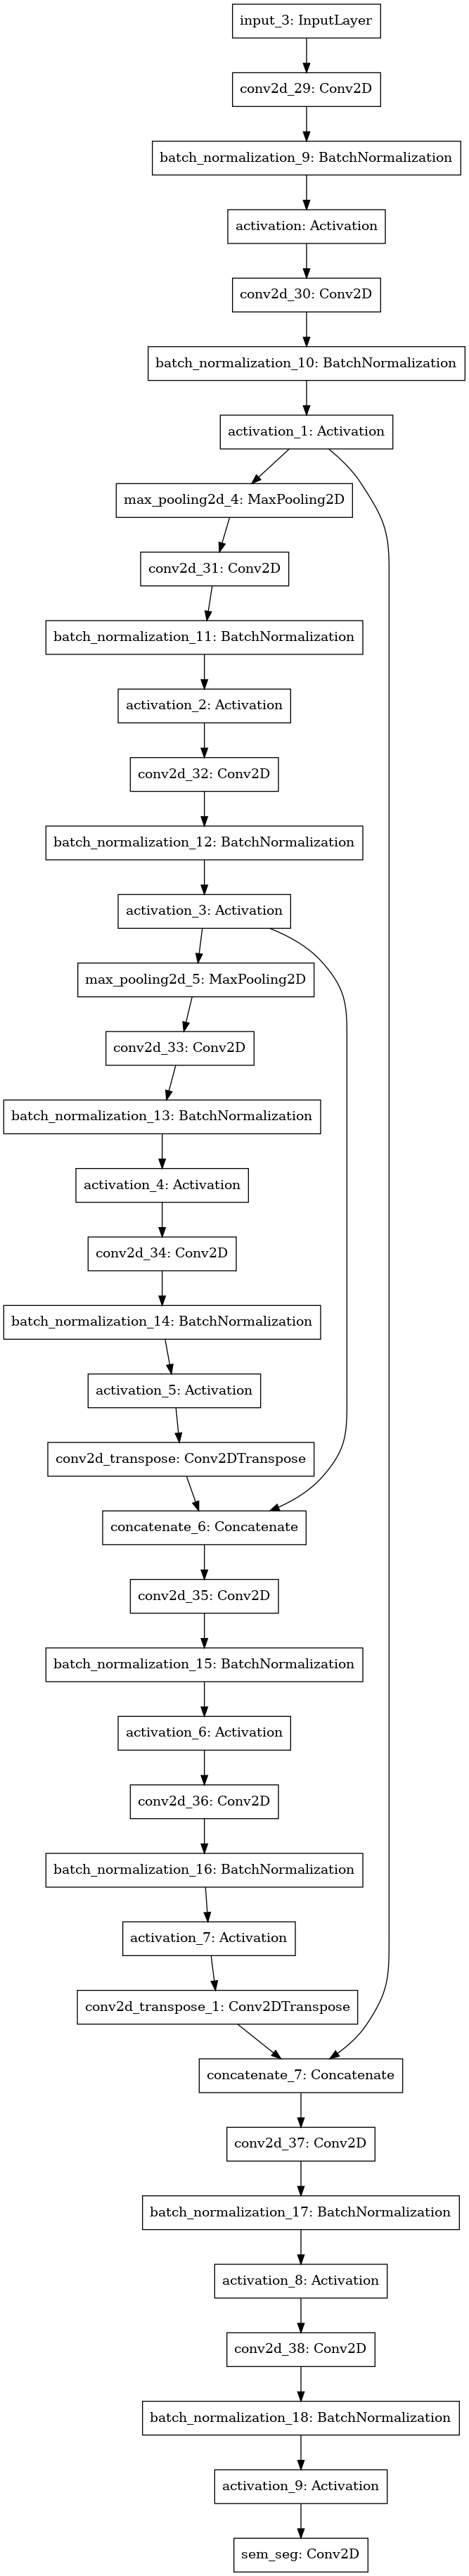

In [38]:
panoptic_ori_model = get_panoptic_model(input_shape=(IMG_SIZE,IMG_SIZE,3), num_classes=TOTAL_CLASSES_CNT)
panoptic_cam_ori_model = get_cam_from_model(panoptic_ori_model)

panoptic_cam_ori_model.summary()
keras.utils.plot_model(panoptic_ori_model, show_shapes=False)

In [39]:
#panoptic_aug_model = get_deeplab_model(input_shape=(IMG_SIZE,IMG_SIZE,3), num_classes=TOTAL_CLASSES_CNT)
#panoptic_cam_aug_model = get_cam_from_model(panoptic_aug_model)

---
## <span style = "background-color: #FFFFDD"> 🏃🏻 Model Training</span>

### <span style = "background-color: #F0E9FF"> 1. Define training performance evaluation methods</span>

In [40]:
def dice_coefficient(target, prediction, smooth=1):
    intersection = tf.reduce_sum(target * prediction)
    union = tf.reduce_sum(target) + tf.reduce_sum(prediction)
    dice = (2. * intersection + smooth) / (union + smooth)

    return dice

In [41]:
def pixel_accuracy(target, prediction):
    # 정수로 변환하여 비교
    y_true = tf.cast(y_true * 255, tf.int32)
    y_pred = tf.cast(tf.round(y_pred * 255), tf.int32)

    # 정확하게 예측된 픽셀의 개수 계산
    correct_pixels = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred), tf.float32))

    # 전체 픽셀의 개수 계산
    total_pixels = tf.reduce_sum(tf.ones_like(y_true, dtype=tf.float32))

    # 픽셀 정확도 계산
    accuracy = correct_pixels / total_pixels

    return accuracy.numpy()

In [42]:
def iou_score(target, prediction):
    target = tf.convert_to_tensor(target, dtype=tf.float32)
    prediction = tf.convert_to_tensor(prediction, dtype=tf.float32)

    intersection = tf.reduce_sum(tf.cast(tf.logical_and(tf.cast(target, tf.bool), tf.cast(prediction, tf.bool)), tf.float32))
    union = tf.reduce_sum(tf.cast(tf.logical_or(tf.cast(target, tf.bool), tf.cast(prediction, tf.bool)), tf.float32))
    
    iou_score = tf.math.divide_no_nan(intersection, union)
    
    return iou_score

### <span style = "background-color: #F0E9FF"> 2. Practice W&B experiment manager</span>

**2-1. Log in W&B**

In [43]:
wandb.login(key = "ae417439e0ad73a8185c8925b83809c0eef9731e")

wandb: Currently logged in as: teddysiah. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /aiffel/.netrc


True

**2-2. Define training configurations**

In [44]:
sweep_config = {"name": "sweep_test_cv",
                "metric": {"name": "val_loss", "goal": "minimize"},
                "method": "random",
                "parameters": {"learning_rate" : {"min" : 0.001, "max" : 0.1},
                               #"epoch" : {"distribution" : "int_uniform", "min" : 5, "max" : 10}
                              }
               }

In [45]:
sweep_id = wandb.sweep(sweep_config,
                       entity = "teddysiah",
                       project = "aiffel_dlthon_test")

Create sweep with ID: xqy7ple9
Sweep URL: https://wandb.ai/teddysiah/aiffel_dlthon_test/sweeps/xqy7ple9


In [46]:
def train(model, augmented_input=False):
    
    # set training data (original or augmented)
    ds_train_input = ds_train_input_original
    ds_train_target = ds_train_target_original
    
    if augmented_input == True:
        ds_train_input = ds_train_input_augmented
        ds_train_target = ds_train_target_augmented
    
    
    ### 모델 학습 시 직접 정의한 metrics를 넣고 싶었으나 잘 되지 않음
    ### 일단 W&B를 사용해본다는 실습 차원에서 "accuracy"를 사용하고 최소한의 epochs만 지정
    
    #def dice_coefficient(target, prediction, smooth=1):
    #    intersection = tf.reduce_sum(target * prediction)
    #    union = tf.reduce_sum(target) + tf.reduce_sum(prediction)
    #    dice = (2. * intersection + smooth) / (union + smooth)
    #    return dice
    
    #def iou_score(target, prediction):
    #    target = tf.convert_to_tensor(target, dtype=tf.float32)
    #    prediction = tf.convert_to_tensor(prediction, dtype=tf.float32)
    #    intersection = tf.reduce_sum(tf.cast(tf.logical_and(tf.cast(target, tf.bool), tf.cast(prediction, tf.bool)), tf.float32))
    #    union = tf.reduce_sum(tf.cast(tf.logical_or(tf.cast(target, tf.bool), tf.cast(prediction, tf.bool)), tf.float32))
    #    iou_score = tf.math.divide_no_nan(intersection, union)
    #    return iou_score
    
    
    # set training model configurations    
    default_config = {"input" : (IMG_SIZE,IMG_SIZE,3),
                      "learning_rate" : 0.005,
                      "optimizer" : "Adam",
                      "metrics" : ["accuracy"],
                      "epoch" : 5,
                      "batch_size" : BATCH_SIZE}

    wandb.init(config = default_config)
    config = wandb.config


    
    # compile the model
    if config.optimizer == "Adam":
        optimizer = keras.optimizers.Adam(learning_rate = config.learning_rate)
    
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=config.metrics)


    # start training the model       
    model.fit(ds_train_input, ds_train_target,
              epochs=config.epoch,
              #steps_per_epoch=STEPS_PER_EPOCH,
              #validation_steps=VALIDATION_STEPS,
              validation_data=(ds_val_input, ds_val_target),
              #callbacks = [WandbCallback(validation_data = (ds_val_input, ds_val_target),
              #                           predictions = 10,
              #                           input_type = "auto",
              #                           output_type = "segmentation_mask")]
             )

    
    # evaluate the model
    test_loss, test_accuracy = model.evaluate(ds_test_input, ds_test_target, verbose=2)
    
    
    # record the evaluation result    
    wandb.log({"Test Accuracy Rate: " : round(test_accuracy * 100, 2),
               "Test Error    Rate: " : round((1 - test_accuracy) * 100, 2)})

**2-3. Train model with W&B tool**

In [47]:
# run the sweep
#wandb.agent(sweep_id, function=train(unet_cam_ori_model), count=10)

### <span style = "background-color: #F0E9FF"> 3. Train U-net models (강다은 담당)</span>

**3-1. Train with original (non-augmented) data**

In [49]:
unet_cam_ori_model.compile(optimizer = "Adam", loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

unet_cam_ori_history = unet_cam_ori_model.fit(ds_train_input_original, ds_train_target_original,
                                  validation_data=(ds_val_input, ds_val_target),
                                  steps_per_epoch=len(ds_train_input_original),
                                  epochs=10,)

Epoch 1/10
140/140 [==============================] - 14s 91ms/step - loss: 1.4283 - accuracy: 0.6893 - val_loss: 1.3737 - val_accuracy: 0.7037
Epoch 2/10
140/140 [==============================] - 13s 91ms/step - loss: 1.4221 - accuracy: 0.6905 - val_loss: 1.3549 - val_accuracy: 0.7054
Epoch 3/10
140/140 [==============================] - 13s 92ms/step - loss: 1.4333 - accuracy: 0.6894 - val_loss: 1.3828 - val_accuracy: 0.7047
Epoch 4/10
140/140 [==============================] - 13s 90ms/step - loss: 1.4181 - accuracy: 0.6893 - val_loss: 1.3541 - val_accuracy: 0.7051
Epoch 5/10
140/140 [==============================] - 13s 90ms/step - loss: 1.4054 - accuracy: 0.6913 - val_loss: 1.3641 - val_accuracy: 0.7054
Epoch 6/10
140/140 [==============================] - 13s 89ms/step - loss: 1.4129 - accuracy: 0.6891 - val_loss: 1.3451 - val_accuracy: 0.7051
Epoch 7/10
140/140 [==============================] - 13s 89ms/step - loss: 1.4033 - accuracy: 0.6890 - val_loss: 1.3629 - val_accuracy:

**3-2. Train with augmented data**

In [ ]:
#unet_cam_aug_model.compile(optimizer = "Adam", loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

#unet_cam_aug_history = unet_cam_aug_model.fit(ds_train_input_augmented, ds_train_target_augmented,
#                                          validation_data=(ds_val_input, ds_val_target),
#                                          steps_per_epoch=len(ds_train_input_original),
#                                          epochs=EPOCHS,)

### <span style = "background-color: #F0E9FF"> 4. Train FCN models (보류)</span>

**4-1. Train with original (non-augmented) data**

In [ ]:
#fcn_cam_ori_model.compile(optimizer = "Adam", loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

#fcn_cam_ori_history = fcn_cam_ori_model.fit(ds_train_input_original, ds_train_target_original,
#                                          validation_data=(ds_val_input, ds_val_target),
#                                          steps_per_epoch=len(ds_train_input_original),
#                                          epochs=EPOCHS,)

**4-2. Train with augmented data**

In [ ]:
#fcn_cam_aug_model.compile(optimizer = "Adam", loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

#fcn_cam_aug_history = unet_cam_aug_model.fit(ds_train_input_augmented, ds_train_target_augmented,
#                                          validation_data=(ds_val_input, ds_val_target),
#                                          steps_per_epoch=len(ds_train_input_original),
#                                          epochs=EPOCHS,)

### <span style = "background-color: #F0E9FF"> 5. Train DeepLab models (김찬중 담당)</span>

**5-1. Train with original (non-augmented) data**

In [ ]:
deeplab_cam_ori_model.compile(optimizer = "Adam", loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

deeplab_cam_ori_history = deeplab_cam_ori_model.fit(ds_train_input_original, ds_train_target_original,
                                          validation_data=(ds_val_input, ds_val_target),
                                          steps_per_epoch=len(ds_train_input_original),
                                          epochs=10,)

**5-2. Train with augmented data**

In [ ]:
#deeplab_cam_aug_model.compile(optimizer = "Adam", loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

#deeplab_cam_aug_history = deeplab_cam_aug_model.fit(ds_train_input_augmented, ds_train_target_augmented,
#                                          validation_data=(ds_val_input, ds_val_target),
#                                          steps_per_epoch=len(ds_train_input_original),
#                                          epochs=EPOCHS,)

### Panoptic

In [62]:
panoptic_cam_ori_model.compile(optimizer = "Adam", loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

panoptic_cam_ori_history = panoptic_cam_ori_model.fit(ds_train_input_original, ds_train_target_original,
                                          validation_data=(ds_val_input, ds_val_target),
                                          steps_per_epoch=len(ds_train_input_original),
                                          epochs=EPOCHS,)

Epoch 1/50
140/140 [==============================] - 8s 48ms/step - loss: 1.4164 - accuracy: 0.6895 - val_loss: 1.7950 - val_accuracy: 0.6623
Epoch 2/50
140/140 [==============================] - 7s 47ms/step - loss: 1.3995 - accuracy: 0.6894 - val_loss: 1.4484 - val_accuracy: 0.7004
Epoch 3/50
140/140 [==============================] - 7s 47ms/step - loss: 1.3896 - accuracy: 0.6892 - val_loss: 1.4360 - val_accuracy: 0.7023
Epoch 4/50
140/140 [==============================] - 7s 48ms/step - loss: 1.3794 - accuracy: 0.6893 - val_loss: 1.3236 - val_accuracy: 0.7054
Epoch 5/50
140/140 [==============================] - 7s 48ms/step - loss: 1.3748 - accuracy: 0.6894 - val_loss: 1.4959 - val_accuracy: 0.7021
Epoch 6/50
140/140 [==============================] - 7s 48ms/step - loss: 1.3659 - accuracy: 0.6893 - val_loss: 1.3955 - val_accuracy: 0.7020
Epoch 7/50
140/140 [==============================] - 7s 47ms/step - loss: 1.3609 - accuracy: 0.6893 - val_loss: 1.3205 - val_accuracy: 0.7028

In [ ]:
#panoptic_cam_aug_model.compile(optimizer = "Adam", loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

#panoptic_cam_aug_history = panoptic_cam_aug_model.fit(ds_train_input_augmented, ds_train_target_augmented,
#                                          validation_data=(ds_val_input, ds_val_target),
#                                          steps_per_epoch=len(ds_train_input_original),
#                                          epochs=EPOCHS,)

### <span style = "background-color: #F0E9FF"> 6. Visualize training history</span>

**3-1. Define history visualizing methods** 

In [51]:
def visualize_history(history):
    fig = plt.figure(figsize=(15,4))
    
    # visualize training & validation loss
    graph1 = fig.add_subplot(1, 4, 1)
    graph1.plot(history.history["loss"], color="lightpink", label="training")
    graph1.plot(history.history["val_loss"], color="palevioletred", label="validation")
    graph1.legend()
    graph1.set_title("L O S S")
    graph1.set_xlabel("epochs")
    graph1.set_ylabel("loss")
    graph1.grid()
        
    # visualize training & validation accuracy
    graph2 = fig.add_subplot(1, 4, 2)
    #graph2.plot(history.history["dice_coefficient"], color="thistle", label="training")
    #graph2.plot(history.history["val_dice_coefficient"], color="orchid", label="validation")
    graph2.plot(history.history["accuracy"], color="thistle", label="training")
    graph2.plot(history.history["val_accuracy"], color="orchid", label="validation")
    graph2.legend()
    #graph2.set_title("D I C E   C O E F F C I E N T")
    graph2.set_title("A C C U R A C Y")
    graph2.set_xlabel("epochs")
    graph2.set_ylabel("coeff")
    graph2.grid()
    
    # visualize training & validation binary accuracy
    graph3 = fig.add_subplot(1, 4, 3)
    #graph3.plot(history.history["pixel_accuracy"], color="wheat", label="training")
    #graph3.plot(history.history["val_pixel_accuracy"], color="orange", label="validation")
    #graph3.legend()
    graph3.set_title("P I X E L   A C C U R A C Y")
    graph3.set_xlabel("epochs")
    graph3.set_ylabel("IOU")
    graph3.grid()
    
    # visualize training & validation binary accuracy
    graph4 = fig.add_subplot(1, 4, 4)
    #graph4.plot(history.history["iou_score"], color="paleturquoise", label="training")
    #graph4.plot(history.history["val_iou_score"], color="lightseagreen", label="validation")
    #graph4.legend()
    graph4.set_title("I O U")
    graph4.set_xlabel("epochs")
    graph4.set_ylabel("IOU")
    graph4.grid()

    fig.tight_layout()
    fig.show()

**3-2. Visualize U-net model training history (강다은 담당)** 

>>> U-net model training evaluation (original data)     : 


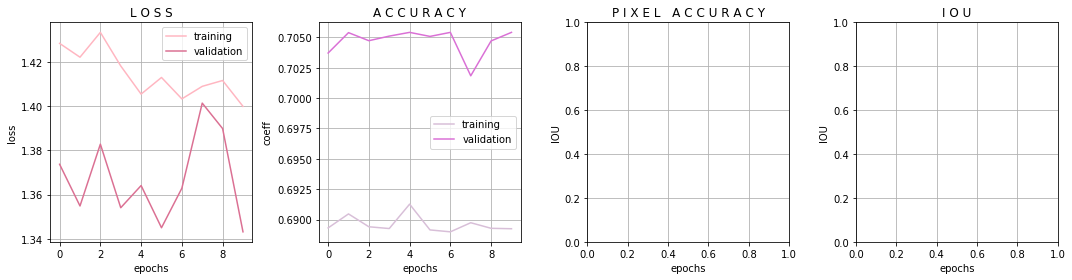

In [52]:
print(">>> U-net model training evaluation (original data)     : ")
visualize_history(unet_cam_ori_history)

In [ ]:
print(">>> U-net model training evaluation (augmented data)    : ")
#visualize_history(unet_cam_aug_history)

**3-3. Visualize FCN model training history (보류)**

In [ ]:
print(">>> FCN model training evaluation (original data)       : ")
#visualize_history(fcn_cam_ori_history)

In [ ]:
print(">>> FCN model training evaluation (augmented data)      : ")
#visualize_history(fcn_cam_aug_history)

**3-4. Visualize DeepLab model training history (김찬중 담당)**

In [ ]:
print(">>> DeepLab model training evaluation (original data)   : ")
visualize_history(deeplab_cam_ori_history)

In [ ]:
print(">>> DeepLab model training evaluation (augmented data)  : ")
#visualize_history(deeplab_cam_aug_history)

**3-5. Visualize Panoptic model training history (조혜원 담당)**

>>> Panoptic model training evaluation (original data)  : 


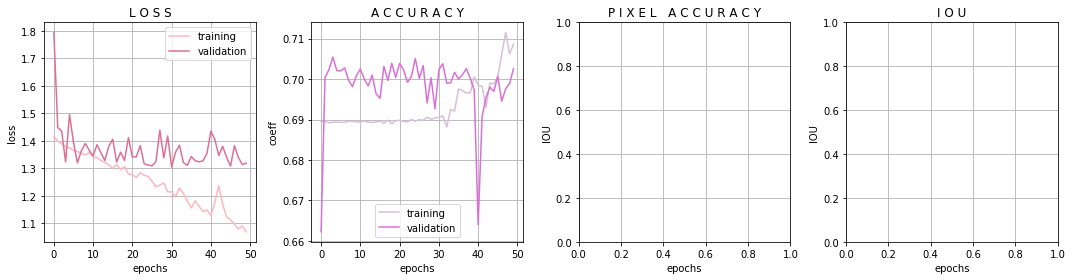

In [63]:
print(">>> Panoptic model training evaluation (original data)  : ")
visualize_history(panoptic_cam_ori_history)

In [ ]:
print(">>> Panoptic model training evaluation (augmented data) : ")
#visualize_history(panoptic_cam_aug_history)

📝 **모델 학습 성능 분석**

- 여기에 각자 분석 내용 적을 것
- 여기에 각자 분석 내용 적을 것
- 여기에 각자 분석 내용 적을 것

---
## <span style = "background-color: #FFFFDD"> 🏃🏻 Experiments</span>

### <span style = "background-color: #F0E9FF"> 1. Define experiment methods</span>

**1-1. Define CAM image generating method**

In [ ]:
# 앞으로 구현할 것 (강다은 휴)

**1-2. Define prediction-based segmentation visualing method**

In [54]:
def get_segmentation_from_prediction(prediction):
    segmentation = np.argmax(prediction, axis=-1)
    segmentation = np.expand_dims(segmentation, axis=-1)
    segmentation = segmentation * 12
    return segmentation

**1-3. Define experimental result displaying method**

In [66]:
def preview_experimental_results(cam1, cam2, predicted1, predicted2, sample_cnt):
    sample_num_list = [random.randint(0, TEST_SAMPLES_CNT-1) for _ in range(sample_cnt)]
     
    for i in range(sample_cnt):
        # get image data from the sample data
        sample_num = sample_num_list[i]
        
        fig = plt.figure(figsize=(15,8))

        ax_input = fig.add_subplot(2, 3, 1)
        ax_input.imshow(ds_test_input[i])
        ax_input.set_title("original input")
        ax_input.axis("off")

        ax_cam1 = fig.add_subplot(2, 3, 2)
        #ax_cam1.imshow()
        ax_cam1.set_title("CAM by original input")
        ax_cam1.axis("off")
        
        ax_cam2 = fig.add_subplot(2, 3, 3)
        #ax_cam2.imshow()
        ax_cam2.set_title("CAM by augmented input")
        ax_cam2.axis("off")

        ax_target = fig.add_subplot(2, 3, 4)
        ax_target.imshow(ds_test_target[i])
        ax_target.set_title("ground-truth segmentation")
        ax_target.axis("off")
        
        ax_pred = fig.add_subplot(2, 3, 5)
        ax_pred.imshow(predicted1[i] / (TOTAL_CLASSES_CNT - 1))
        ax_pred.set_title("predicted by original input")
        ax_pred.axis("off")
        
        ax_pred = fig.add_subplot(2, 3, 6)
        #ax_pred.imshow(predicted2[i] / (TOTAL_CLASSES_CNT - 1))
        ax_pred.set_title("predicted by augmented input")
        ax_pred.axis("off")

        plt.tight_layout()
        plt.show()

### <span style = "background-color: #F0E9FF"> 2. Predict segmentation with the trained model</span>

**2-1. Predict segmentation with U-net model (강다은 담당)**

In [56]:
#unet_cam1 = ?
unet_predicted1 = unet_cam_ori_model.predict(ds_test_input)
unet_segmented1 = get_segmentation_from_prediction(unet_predicted1)

In [ ]:
#unet_cam2 = ?
#unet_predicted2 = unet_cam_aug_model.predict(ds_test_input)
#unet_segmented2 = get_segmentation_from_prediction(unet_predicted2)

**2-2. Predict segmentation with FCN model (보류)**

In [ ]:
#fcn_cam1 = ?
#fcn_predicted1 = fcn_cam_ori_model.predict(ds_test_input)

In [ ]:
#fcn_cam2 = ?
#fcn_predicted2 = fcn_cam_aug_model.predict(ds_test_input)

**2-3. Predict segmentation with DeepLab model (김찬중 담당)**

In [57]:
#deeplab_cam1 = ?
deeplab_predicted1 = deeplab_cam_ori_model.predict(ds_test_input)
deeplab_segmented1 = get_segmentation_from_prediction(deeplab_predicted1)

In [ ]:
#deeplab_cam2 = ?
#deeplab_predicted2 = deeplab_cam_aug_model.predict(ds_test_input)
#deeplab_segmented2 = get_segmentation_from_prediction(deeplab_predicted2)

**2-4. Predict segmentation with Panoptic model (김찬중 담당)**

In [64]:
#panoptic_cam1 = ?
panoptic_predicted1 = panoptic_cam_ori_model.predict(ds_test_input)
panoptic_segmented1 = get_segmentation_from_prediction(panoptic_predicted1)

In [ ]:
#panoptic_cam2 = ?
#panoptic_predicted2 = deeplab_cam_aug_model.predict(ds_test_input)
#panoptic_segmented2 = get_segmentation_from_prediction(panoptic_predicted2)

### <span style = "background-color: #F0E9FF"> 3. Display experimental results</span>

**3-1. Display experimental results of U-net model (강다은 담당)**

TypeError: 'NoneType' object is not subscriptable

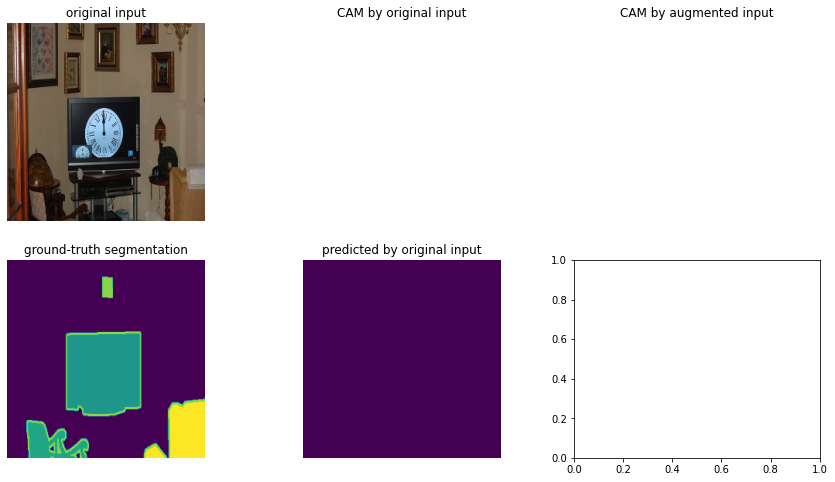

In [59]:
preview_experimental_results(None, None, unet_segmented1, None, 5)

**3-2. Display experimental results of FCN model (보류)**

In [ ]:
#preview_experimental_results(fcn_cam1, fcn_cam2, fcn_predicted1, fcn_predicted2, 10)

**3-3. Display experimental results of DeepLab model (김찬중 담당)**

In [ ]:
preview_experimental_results(None, None, deeplab_segmented1, None, 5)

**3-4. Display experimental results of Panoptic model (조혜원 담당)**

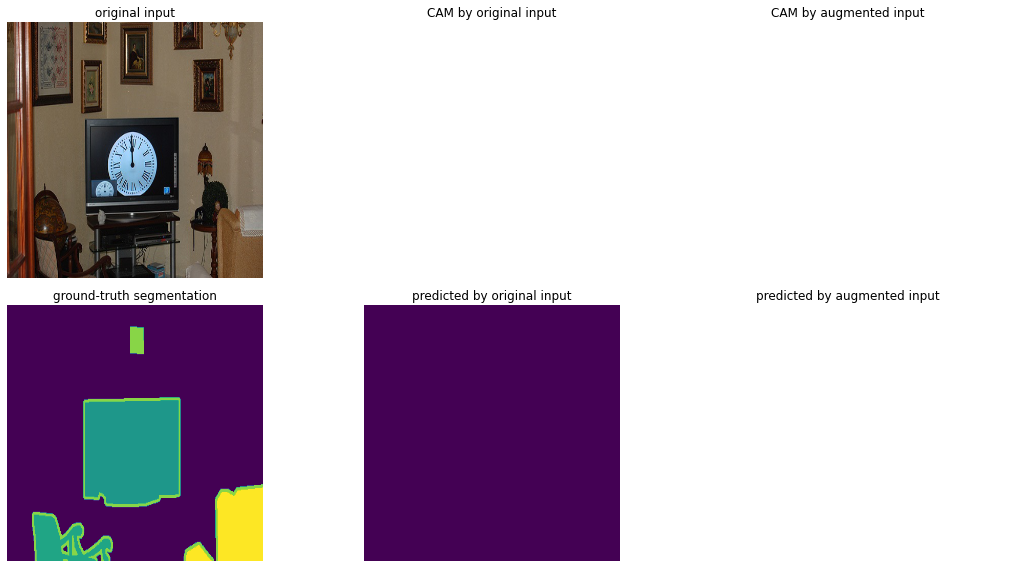

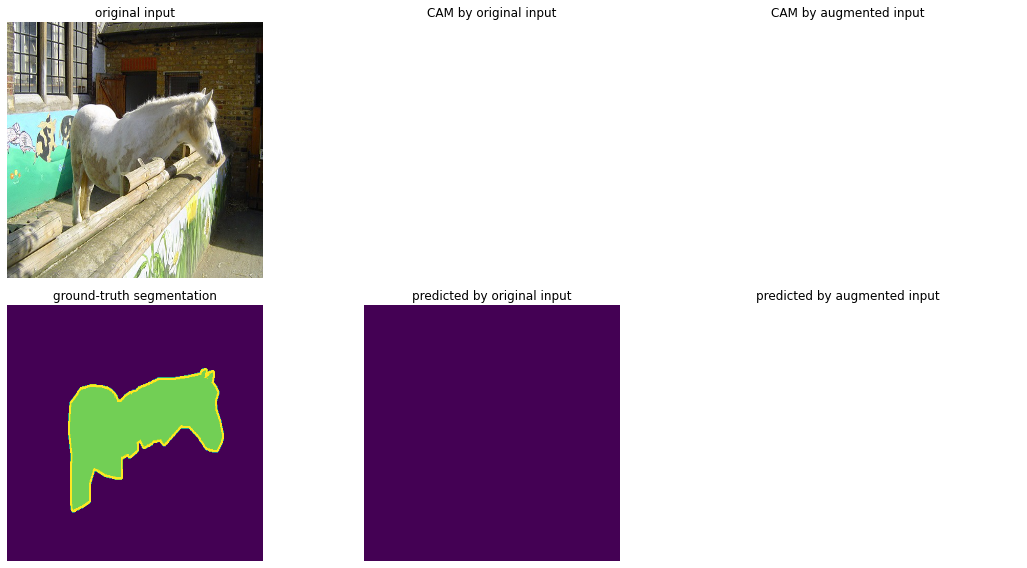

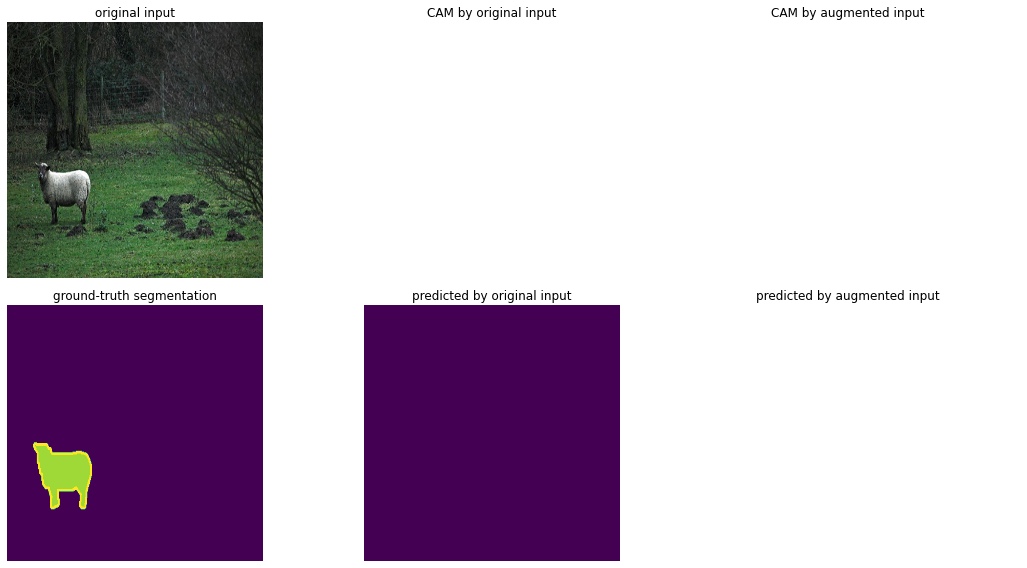

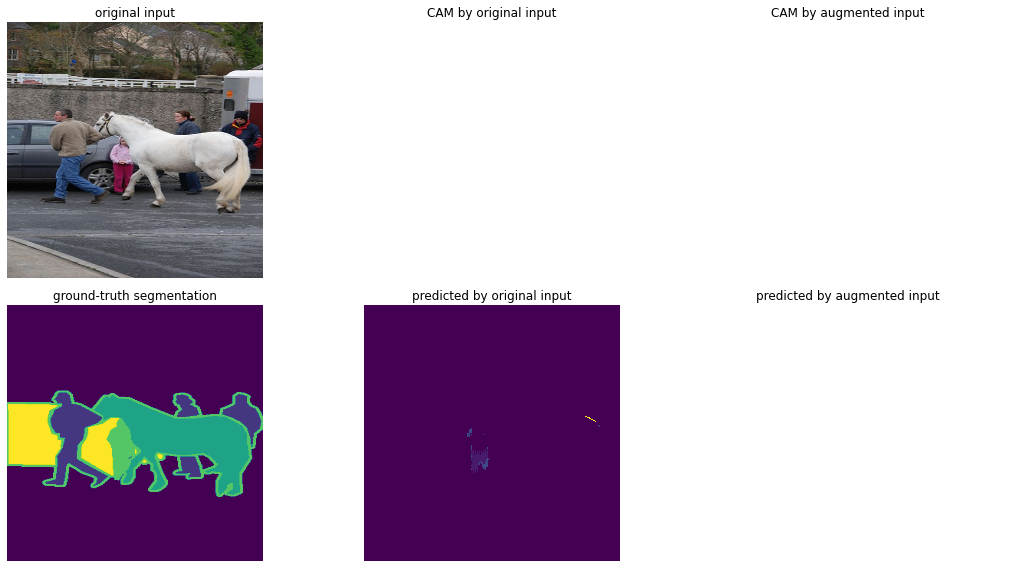

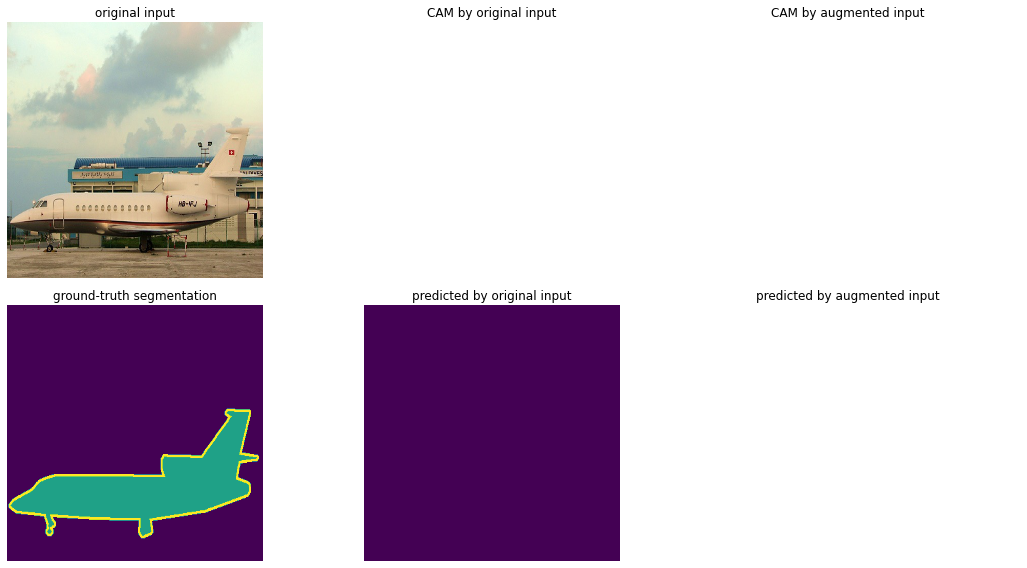

In [67]:
preview_experimental_results(None, None, panoptic_segmented1, None, 5)

---
## <span style = "background-color: #FFFFDD"> 🏃🏻 Conclusion</span>

**📝 실험결과 분석**
- 분석 1
- 분석 2
- 분석 3

**📝 회고록**  
- 회고 1
- 회고 2
- 회고 3

---